What if you have data and a general model and would like to evaluate the
probability that the fitted model outcomes would have had a given behavior?
The purpose of this tutorial is to demonstrate a fast workflow for doing exactly
this. It composes together a few different pieces of the SciML ecosystem:

1. Parameter estimation with uncertainty with Bayesian differential equations by
   integrating the differentiable differential equation solvers with the
   [Turing.jl library](https://turing.ml/dev/).
2. Fast calculation of probabilistic estimates of differential equation solutions
   with parametric uncertainty using the Koopman expectation.
3. GPU-acceleration of batched differential equation solves.

Let's dive right in.

## Bayesian Parameter Estimation with Uncertainty

Let's start by importing all of the necessary libraries:

In [2]:
using Turing, Distributions, DifferentialEquations
using MCMCChains, Plots, StatsPlots
using Random
using DiffEqUncertainty
using KernelDensity, DiffEqUncertainty
using Cuba, DiffEqGPU

Random.seed!(1);

For this tutorial we will use the Lotka-Volterra equation:

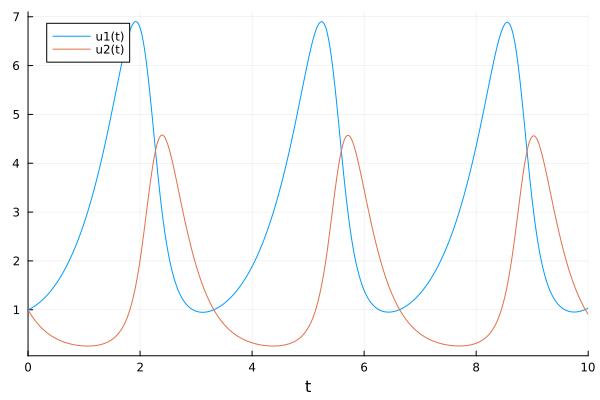

In [3]:
function lotka_volterra(du,u,p,t)
  @inbounds begin
      x = u[1]
      y = u[2]
      α = p[1]
      β = p[2]
      γ = p[3]
      δ = p[4]
      du[1] = (α - β*y)*x
      du[2] = (δ*x - γ)*y
  end
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob1 = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob1,Tsit5())
plot(sol)

From the Lotka-Volterra equation we will generate a dataset with known parameters:

In [4]:
sol1 = solve(prob1,Tsit5(),saveat=0.1)

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  ⋮
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0
u: 101-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0610780673356455, 0.8210842775886171]
 [1.1440276717257598, 0.6790526689784505]
 [1.2491712125724483, 0.5668931465841183]
 [1.377644570563638, 0.4788129513795158]
 [1.531230817748013, 0.41015646708661463]
 [1.7122697558187638, 0.3572654487994841]
 [1.9235782758301574, 0.31734720616177187]
 [2.168391089699407, 0.28838884378732427]
 [2.450250667140253, 0.2690537093960073]
 ⋮
 [1.817282321955544, 4.064946595043298]
 [1.4427612988383434, 3.539737578046503]
 [1.208908107884442, 2.9914550030313953]
 [1.068592596962787, 2.482072920162587]
 [0.9910229623276097, 2.0372445701968505]
 [0.957421348475831, 1.6632055724973922]
 [0.9569793912886637, 1.3555870283301144]
 [0.98356090632007, 1.1062868199419809]
 [1.0337581256020674, 0.9063703842886032]

Now let's assume our dataset should have noise. We can add this noise in and
plot the noisy data against the generating set:

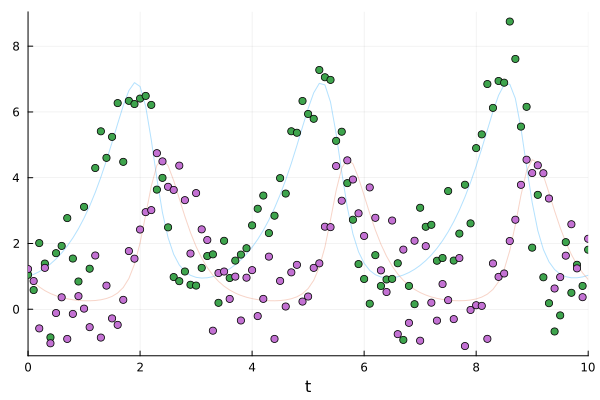

In [5]:
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

Now let's assume that all we know is the data `odedata` and the model form.
What we want to do is use the data to inform us of the parameters, but also
get a probabilistic sense of the uncertainty around our parameter estimate. This
is done via Bayesian estimation. For a full look at Bayesian estimation of
differential equations, look at the [Bayesian differential equation](https://turing.ml/dev/tutorials/10-bayesiandiffeq/)
tutorial from Turing.jl.

Following that tutorial, we choose a set of priors and perform `NUTS` sampling
to arrive at the MCMC chain:

In [6]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),1.0,2.0)
    β ~ truncated(Normal(1.2,0.5),0.5,1.5)
    γ ~ truncated(Normal(3.0,0.5),2,4)
    δ ~ truncated(Normal(1.0,0.5),0.5,1.5)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.45),1000), chainscat, 1:3)

Sampling   0%|█                                         |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\ajaoo\.julia\packages\Turing\dl9my\src\inference\hmc.jl:191


Sampling   0%|█                                         |  ETA: 1:09:51
Sampling   1%|█                                         |  ETA: 0:34:49
Sampling   1%|█                                         |  ETA: 0:23:07
Sampling   2%|█                                         |  ETA: 0:17:16
Sampling   2%|█                                         |  ETA: 0:13:45
Sampling   3%|██                                        |  ETA: 0:11:25
Sampling   3%|██                                        |  ETA: 0:09:45
Sampling   4%|██                                        |  ETA: 0:08:29


Sampling   4%|██                                        |  ETA: 0:07:31
Sampling   5%|██                                        |  ETA: 0:06:44
Sampling   5%|███                                       |  ETA: 0:06:06
Sampling   6%|███                                       |  ETA: 0:05:34
Sampling   6%|███                                       |  ETA: 0:05:07
Sampling   7%|███                                       |  ETA: 0:04:43
Sampling   7%|███                                       |  ETA: 0:04:24
Sampling   7%|████                                      |  ETA: 0:04:06


Sampling   8%|████                                      |  ETA: 0:03:51
Sampling   8%|████                                      |  ETA: 0:03:37
Sampling   9%|████                                      |  ETA: 0:03:25
Sampling   9%|████                                      |  ETA: 0:03:13
Sampling  10%|█████                                     |  ETA: 0:03:03
Sampling  10%|█████                                     |  ETA: 0:02:54
Sampling  11%|█████                                     |  ETA: 0:02:46
Sampling  11%|█████                                     |  ETA: 0:02:38


Sampling  12%|█████                                     |  ETA: 0:02:31
Sampling  12%|██████                                    |  ETA: 0:02:25
Sampling  13%|██████                                    |  ETA: 0:02:19
Sampling  13%|██████                                    |  ETA: 0:02:13
Sampling  14%|██████                                    |  ETA: 0:02:08


Sampling  14%|██████                                    |  ETA: 0:02:04
Sampling  14%|███████                                   |  ETA: 0:01:59
Sampling  15%|███████                                   |  ETA: 0:01:55
Sampling  15%|███████                                   |  ETA: 0:01:51
Sampling  16%|███████                                   |  ETA: 0:01:47
Sampling  16%|███████                                   |  ETA: 0:01:44
Sampling  17%|████████                                  |  ETA: 0:01:40


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  17%|████████                                  |  ETA: 0:01:38
Sampling  18%|████████                                  |  ETA: 0:01:35
Sampling  18%|████████                                  |  ETA: 0:01:32
Sampling  19%|████████                                  |  ETA: 0:01:29
Sampling  19%|█████████                                 |  ETA: 0:01:27
Sampling  20%|█████████                                 |  ETA: 0:01:24
Sampling  20%|█████████                                 |  ETA: 0:01:22


Sampling  21%|█████████                                 |  ETA: 0:01:20
Sampling  21%|█████████                                 |  ETA: 0:01:17
Sampling  21%|██████████                                |  ETA: 0:01:15
Sampling  22%|██████████                                |  ETA: 0:01:13
Sampling  22%|██████████                                |  ETA: 0:01:11
Sampling  23%|██████████                                |  ETA: 0:01:10
Sampling  23%|██████████                                |  ETA: 0:01:08
Sampling  24%|██████████                                |  ETA: 0:01:06


Sampling  24%|███████████                               |  ETA: 0:01:05
Sampling  25%|███████████                               |  ETA: 0:01:03
Sampling  25%|███████████                               |  ETA: 0:01:01
Sampling  26%|███████████                               |  ETA: 0:01:00
Sampling  26%|███████████                               |  ETA: 0:00:59
Sampling  27%|████████████                              |  ETA: 0:00:57
Sampling  27%|████████████                              |  ETA: 0:00:56


Sampling  28%|████████████                              |  ETA: 0:00:55
Sampling  28%|████████████                              |  ETA: 0:00:54
Sampling  28%|████████████                              |  ETA: 0:00:52
Sampling  29%|█████████████                             |  ETA: 0:00:51


Sampling  29%|█████████████                             |  ETA: 0:00:50
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  30%|█████████████                             |  ETA: 0:00:49
Sampling  30%|█████████████                             |  ETA: 0:00:48
Sampling  31%|█████████████                             |  ETA: 0:00:47
Sampling  31%|██████████████                            |  ETA: 0:00:46
Sampling  32%|██████████████                            |  ETA: 0:00:45


Sampling  32%|██████████████                            |  ETA: 0:00:44
Sampling  33%|██████████████                            |  ETA: 0:00:43
Sampling  33%|██████████████                            |  ETA: 0:00:42
Sampling  34%|███████████████                           |  ETA: 0:00:42
Sampling  34%|███████████████                           |  ETA: 0:00:41
Sampling  35%|███████████████                           |  ETA: 0:00:40
Sampling  35%|███████████████                           |  ETA: 0:00:39
Sampling  35%|███████████████                           |  ETA: 0:00:38


Sampling  36%|████████████████                          |  ETA: 0:00:38
Sampling  36%|████████████████                          |  ETA: 0:00:37
Sampling  37%|████████████████                          |  ETA: 0:00:36
Sampling  37%|████████████████                          |  ETA: 0:00:35
Sampling  38%|████████████████                          |  ETA: 0:00:35
Sampling  38%|█████████████████                         |  ETA: 0:00:34
Sampling  39%|█████████████████                         |  ETA: 0:00:33
Sampling  39%|█████████████████                         |  ETA: 0:00:33
Sampling  40%|█████████████████                         |  ETA: 0:00:32
Sampling  40%|█████████████████                         |  ETA: 0:00:32
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  41%|██████████████████                        

Sampling  41%|██████████████████                        |  ETA: 0:00:30
Sampling  42%|██████████████████                        |  ETA: 0:00:30
Sampling  42%|██████████████████                        |  ETA: 0:00:29
Sampling  42%|██████████████████                        |  ETA: 0:00:29
Sampling  43%|███████████████████                       |  ETA: 0:00:28
Sampling  43%|███████████████████                       |  ETA: 0:00:28
Sampling  44%|███████████████████                       |  ETA: 0:00:27
Sampling  44%|███████████████████                       |  ETA: 0:00:27
Sampling  45%|███████████████████                       |  ETA: 0:00:26


Sampling  45%|████████████████████                      |  ETA: 0:00:26
Sampling  46%|████████████████████                      |  ETA: 0:00:25
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  46%|████████████████████                      |  ETA: 0:00:25


Sampling  47%|████████████████████                      |  ETA: 0:00:25
Sampling  47%|████████████████████                      |  ETA: 0:00:24
Sampling  48%|████████████████████                      |  ETA: 0:00:24
Sampling  48%|█████████████████████                     |  ETA: 0:00:23
Sampling  49%|█████████████████████                     |  ETA: 0:00:23
Sampling  49%|█████████████████████                     |  ETA: 0:00:22


Sampling  49%|█████████████████████                     |  ETA: 0:00:22
Sampling  50%|█████████████████████                     |  ETA: 0:00:22
Sampling  50%|██████████████████████                    |  ETA: 0:00:21
Sampling  51%|██████████████████████                    |  ETA: 0:00:21
Sampling  51%|██████████████████████                    |  ETA: 0:00:21


Sampling  52%|██████████████████████                    |  ETA: 0:00:20
Sampling  52%|██████████████████████                    |  ETA: 0:00:20
Sampling  53%|███████████████████████                   |  ETA: 0:00:19
Sampling  53%|███████████████████████                   |  ETA: 0:00:19
Sampling  54%|███████████████████████                   |  ETA: 0:00:19


Sampling  54%|███████████████████████                   |  ETA: 0:00:18
Sampling  55%|███████████████████████                   |  ETA: 0:00:18
Sampling  55%|████████████████████████                  |  ETA: 0:00:18
Sampling  56%|████████████████████████                  |  ETA: 0:00:17
Sampling  56%|████████████████████████                  |  ETA: 0:00:17


Sampling  56%|████████████████████████                  |  ETA: 0:00:17
Sampling  57%|████████████████████████                  |  ETA: 0:00:17
Sampling  57%|█████████████████████████                 |  ETA: 0:00:16
Sampling  58%|█████████████████████████                 |  ETA: 0:00:16


Sampling  58%|█████████████████████████                 |  ETA: 0:00:16
Sampling  59%|█████████████████████████                 |  ETA: 0:00:15
Sampling  59%|█████████████████████████                 |  ETA: 0:00:15
Sampling  60%|██████████████████████████                |  ETA: 0:00:15
Sampling  60%|██████████████████████████                |  ETA: 0:00:15
Sampling  61%|██████████████████████████                |  ETA: 0:00:14


Sampling  61%|██████████████████████████                |  ETA: 0:00:14
Sampling  62%|██████████████████████████                |  ETA: 0:00:14
Sampling  62%|███████████████████████████               |  ETA: 0:00:14
Sampling  63%|███████████████████████████               |  ETA: 0:00:13
Sampling  63%|███████████████████████████               |  ETA: 0:00:13
Sampling  63%|███████████████████████████               |  ETA: 0:00:13
Sampling  64%|███████████████████████████               |  ETA: 0:00:13
Sampling  64%|████████████████████████████              |  ETA: 0:00:12


Sampling  65%|████████████████████████████              |  ETA: 0:00:12
Sampling  65%|████████████████████████████              |  ETA: 0:00:12
Sampling  66%|████████████████████████████              |  ETA: 0:00:12
Sampling  66%|████████████████████████████              |  ETA: 0:00:11


Sampling  67%|█████████████████████████████             |  ETA: 0:00:11
Sampling  67%|█████████████████████████████             |  ETA: 0:00:11
Sampling  68%|█████████████████████████████             |  ETA: 0:00:11
Sampling  68%|█████████████████████████████             |  ETA: 0:00:10
Sampling  69%|█████████████████████████████             |  ETA: 0:00:10
Sampling  69%|██████████████████████████████            |  ETA: 0:00:10


Sampling  70%|██████████████████████████████            |  ETA: 0:00:10
Sampling  70%|██████████████████████████████            |  ETA: 0:00:10
Sampling  70%|██████████████████████████████            |  ETA: 0:00:09


Sampling  71%|██████████████████████████████            |  ETA: 0:00:09
Sampling  71%|██████████████████████████████            |  ETA: 0:00:09
Sampling  72%|███████████████████████████████           |  ETA: 0:00:09
Sampling  72%|███████████████████████████████           |  ETA: 0:00:09


Sampling  73%|███████████████████████████████           |  ETA: 0:00:08
Sampling  73%|███████████████████████████████           |  ETA: 0:00:08
Sampling  74%|███████████████████████████████           |  ETA: 0:00:08
Sampling  74%|████████████████████████████████          |  ETA: 0:00:08
Sampling  75%|████████████████████████████████          |  ETA: 0:00:08


Sampling  75%|████████████████████████████████          |  ETA: 0:00:08
Sampling  76%|████████████████████████████████          |  ETA: 0:00:07
Sampling  76%|████████████████████████████████          |  ETA: 0:00:07
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:07
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:07


Sampling  77%|█████████████████████████████████         |  ETA: 0:00:07
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:06
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:06
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:06
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:06
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:06


Sampling  80%|██████████████████████████████████        |  ETA: 0:00:06
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:05
Sampling  81%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:05


Sampling  84%|████████████████████████████████████      |  ETA: 0:00:04
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:04
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:04
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:04
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:04


Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:04
Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:04
Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:03
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:03
Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:03


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:02
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:02
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:02


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:01
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:01
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:01
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:01


Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:24


Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\ajaoo\.julia\packages\Turing\dl9my\src\inference\hmc.jl:191
Sampling   0%|█                                         |  ETA: 0:00:02
Sampling   1%|█                                         |  ETA: 0:00:02
Sampling   1%|█                                         |  ETA: 0:00:01
Sampling   2%|█                                         |  ETA: 0:00:02
Sampling   2%|█                                         |  ETA: 0:00:02
Sampling   3%|██                                        |  ETA: 0:00:03
Sampling   3%|██                                        |  ETA: 0:00:03
Sampling   4%|██                                        |  ETA: 0:00:02


Sampling   4%|██                                        |  ETA: 0:00:02
Sampling   5%|██                                        |  ETA: 0:00:02
Sampling   5%|███                                       |  ETA: 0:00:02
Sampling   6%|███                                       |  ETA: 0:00:02
Sampling   6%|███                                       |  ETA: 0:00:02
Sampling   7%|███                                       |  ETA: 0:00:02
Sampling   7%|███                                       |  ETA: 0:00:02
Sampling   7%|████                                      |  ETA: 0:00:02


Sampling   8%|████                                      |  ETA: 0:00:03
Sampling   8%|████                                      |  ETA: 0:00:02
Sampling   9%|████                                      |  ETA: 0:00:02
Sampling   9%|████                                      |  ETA: 0:00:03
Sampling  10%|█████                                     |  ETA: 0:00:03
Sampling  10%|█████                                     |  ETA: 0:00:02
Sampling  11%|█████                                     |  ETA: 0:00:03


Sampling  11%|█████                                     |  ETA: 0:00:03
Sampling  12%|█████                                     |  ETA: 0:00:03
Sampling  12%|██████                                    |  ETA: 0:00:02
Sampling  13%|██████                                    |  ETA: 0:00:03
Sampling  13%|██████                                    |  ETA: 0:00:03
Sampling  14%|██████                                    |  ETA: 0:00:02
Sampling  14%|██████                                    |  ETA: 0:00:02
Sampling  14%|███████                                   |  ETA: 0:00:02


Sampling  15%|███████                                   |  ETA: 0:00:02
Sampling  15%|███████                                   |  ETA: 0:00:02
Sampling  16%|███████                                   |  ETA: 0:00:02
Sampling  16%|███████                                   |  ETA: 0:00:02
Sampling  17%|████████                                  |  ETA: 0:00:02


Sampling  17%|████████                                  |  ETA: 0:00:03
Sampling  18%|████████                                  |  ETA: 0:00:03
Sampling  18%|████████                                  |  ETA: 0:00:03
Sampling  19%|████████                                  |  ETA: 0:00:03
Sampling  19%|█████████                                 |  ETA: 0:00:03
Sampling  20%|█████████                                 |  ETA: 0:00:03
Sampling  20%|█████████                                 |  ETA: 0:00:03
Sampling  21%|█████████                                 |  ETA: 0:00:03
Sampling  21%|█████████                                 |  ETA: 0:00:02


Sampling  21%|██████████                                |  ETA: 0:00:02
Sampling  22%|██████████                                |  ETA: 0:00:02
Sampling  22%|██████████                                |  ETA: 0:00:02
Sampling  23%|██████████                                |  ETA: 0:00:02
Sampling  23%|██████████                                |  ETA: 0:00:02
Sampling  24%|██████████                                |  ETA: 0:00:02
Sampling  24%|███████████                               |  ETA: 0:00:02
Sampling  25%|███████████                               |  ETA: 0:00:02


Sampling  25%|███████████                               |  ETA: 0:00:02
Sampling  26%|███████████                               |  ETA: 0:00:02
Sampling  26%|███████████                               |  ETA: 0:00:02
Sampling  27%|████████████                              |  ETA: 0:00:02
Sampling  27%|████████████                              |  ETA: 0:00:02
Sampling  28%|████████████                              |  ETA: 0:00:02
Sampling  28%|████████████                              |  ETA: 0:00:02
Sampling  28%|████████████                              |  ETA: 0:00:02
Sampling  29%|█████████████                             |  ETA: 0:00:02


Sampling  29%|█████████████                             |  ETA: 0:00:02
Sampling  30%|█████████████                             |  ETA: 0:00:02
Sampling  30%|█████████████                             |  ETA: 0:00:02
Sampling  31%|█████████████                             |  ETA: 0:00:02
Sampling  31%|██████████████                            |  ETA: 0:00:02
Sampling  32%|██████████████                            |  ETA: 0:00:02
Sampling  32%|██████████████                            |  ETA: 0:00:02
Sampling  33%|██████████████                            |  ETA: 0:00:02
Sampling  33%|██████████████                            |  ETA: 0:00:02


Sampling  34%|███████████████                           |  ETA: 0:00:02
Sampling  34%|███████████████                           |  ETA: 0:00:02
Sampling  35%|███████████████                           |  ETA: 0:00:02
Sampling  35%|███████████████                           |  ETA: 0:00:02
Sampling  35%|███████████████                           |  ETA: 0:00:02


Sampling  36%|████████████████                          |  ETA: 0:00:02
Sampling  36%|████████████████                          |  ETA: 0:00:02
Sampling  37%|████████████████                          |  ETA: 0:00:02
Sampling  37%|████████████████                          |  ETA: 0:00:02
Sampling  38%|████████████████                          |  ETA: 0:00:02
Sampling  38%|█████████████████                         |  ETA: 0:00:02
Sampling  39%|█████████████████                         |  ETA: 0:00:02
Sampling  39%|█████████████████                         |  ETA: 0:00:02


Sampling  40%|█████████████████                         |  ETA: 0:00:02
Sampling  40%|█████████████████                         |  ETA: 0:00:02
Sampling  41%|██████████████████                        |  ETA: 0:00:02
Sampling  41%|██████████████████                        |  ETA: 0:00:02
Sampling  42%|██████████████████                        |  ETA: 0:00:02
Sampling  42%|██████████████████                        |  ETA: 0:00:02


Sampling  42%|██████████████████                        |  ETA: 0:00:02
Sampling  43%|███████████████████                       |  ETA: 0:00:02
Sampling  43%|███████████████████                       |  ETA: 0:00:02
Sampling  44%|███████████████████                       |  ETA: 0:00:02
Sampling  44%|███████████████████                       |  ETA: 0:00:02
Sampling  45%|███████████████████                       |  ETA: 0:00:02
Sampling  45%|████████████████████                      |  ETA: 0:00:02


Sampling  46%|████████████████████                      |  ETA: 0:00:02
Sampling  46%|████████████████████                      |  ETA: 0:00:02
Sampling  47%|████████████████████                      |  ETA: 0:00:02
Sampling  47%|████████████████████                      |  ETA: 0:00:02
Sampling  48%|████████████████████                      |  ETA: 0:00:02
Sampling  48%|█████████████████████                     |  ETA: 0:00:02
Sampling  49%|█████████████████████                     |  ETA: 0:00:02
Sampling  49%|█████████████████████                     |  ETA: 0:00:02


Sampling  49%|█████████████████████                     |  ETA: 0:00:02
Sampling  50%|█████████████████████                     |  ETA: 0:00:02
Sampling  50%|██████████████████████                    |  ETA: 0:00:02
Sampling  51%|██████████████████████                    |  ETA: 0:00:02
Sampling  51%|██████████████████████                    |  ETA: 0:00:02
Sampling  52%|██████████████████████                    |  ETA: 0:00:02


Sampling  52%|██████████████████████                    |  ETA: 0:00:02
Sampling  53%|███████████████████████                   |  ETA: 0:00:02
Sampling  53%|███████████████████████                   |  ETA: 0:00:02
Sampling  54%|███████████████████████                   |  ETA: 0:00:02
Sampling  54%|███████████████████████                   |  ETA: 0:00:02
Sampling  55%|███████████████████████                   |  ETA: 0:00:02


Sampling  55%|████████████████████████                  |  ETA: 0:00:02
Sampling  56%|████████████████████████                  |  ETA: 0:00:02
Sampling  56%|████████████████████████                  |  ETA: 0:00:01
Sampling  56%|████████████████████████                  |  ETA: 0:00:01
Sampling  57%|████████████████████████                  |  ETA: 0:00:01
Sampling  57%|█████████████████████████                 |  ETA: 0:00:01


Sampling  58%|█████████████████████████                 |  ETA: 0:00:01
Sampling  58%|█████████████████████████                 |  ETA: 0:00:01
Sampling  59%|█████████████████████████                 |  ETA: 0:00:01
Sampling  59%|█████████████████████████                 |  ETA: 0:00:01
Sampling  60%|██████████████████████████                |  ETA: 0:00:01
Sampling  60%|██████████████████████████                |  ETA: 0:00:01
Sampling  61%|██████████████████████████                |  ETA: 0:00:01


Sampling  61%|██████████████████████████                |  ETA: 0:00:01
Sampling  62%|██████████████████████████                |  ETA: 0:00:01
Sampling  62%|███████████████████████████               |  ETA: 0:00:01
Sampling  63%|███████████████████████████               |  ETA: 0:00:01
Sampling  63%|███████████████████████████               |  ETA: 0:00:01
Sampling  63%|███████████████████████████               |  ETA: 0:00:01
Sampling  64%|███████████████████████████               |  ETA: 0:00:01


Sampling  64%|████████████████████████████              |  ETA: 0:00:01
Sampling  65%|████████████████████████████              |  ETA: 0:00:01
Sampling  65%|████████████████████████████              |  ETA: 0:00:01
Sampling  66%|████████████████████████████              |  ETA: 0:00:01
Sampling  66%|████████████████████████████              |  ETA: 0:00:01


Sampling  67%|█████████████████████████████             |  ETA: 0:00:01
Sampling  67%|█████████████████████████████             |  ETA: 0:00:01
Sampling  68%|█████████████████████████████             |  ETA: 0:00:01
Sampling  68%|█████████████████████████████             |  ETA: 0:00:01
Sampling  69%|█████████████████████████████             |  ETA: 0:00:01
Sampling  69%|██████████████████████████████            |  ETA: 0:00:01
Sampling  70%|██████████████████████████████            |  ETA: 0:00:01


Sampling  70%|██████████████████████████████            |  ETA: 0:00:01
Sampling  70%|██████████████████████████████            |  ETA: 0:00:01
Sampling  71%|██████████████████████████████            |  ETA: 0:00:01
Sampling  71%|██████████████████████████████            |  ETA: 0:00:01
Sampling  72%|███████████████████████████████           |  ETA: 0:00:01
Sampling  72%|███████████████████████████████           |  ETA: 0:00:01
Sampling  73%|███████████████████████████████           |  ETA: 0:00:01


Sampling  73%|███████████████████████████████           |  ETA: 0:00:01
Sampling  74%|███████████████████████████████           |  ETA: 0:00:01
Sampling  74%|████████████████████████████████          |  ETA: 0:00:01
Sampling  75%|████████████████████████████████          |  ETA: 0:00:01
Sampling  75%|████████████████████████████████          |  ETA: 0:00:01


Sampling  76%|████████████████████████████████          |  ETA: 0:00:01
Sampling  76%|████████████████████████████████          |  ETA: 0:00:01
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:01


Sampling  79%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  81%|███████████████████████████████████       |  ETA: 0:00:01


Sampling  82%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:01


Sampling  84%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:01
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:00


Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:00


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:00


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:00


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:03


Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\ajaoo\.julia\packages\Turing\dl9my\src\inference\hmc.jl:191
Sampling   0%|█                                         |  ETA: 0:00:03
Sampling   1%|█                                         |  ETA: 0:00:02
Sampling   1%|█                                         |  ETA: 0:00:01
Sampling   2%|█                                         |  ETA: 0:00:02
Sampling   2%|█                                         |  ETA: 0:00:02
Sampling   3%|██                                        |  ETA: 0:00:02
Sampling   3%|██                                        |  ETA: 0:00:02
Sampling   4%|██                                        |  ETA: 0:00:03


Sampling   4%|██                                        |  ETA: 0:00:03
Sampling   5%|██                                        |  ETA: 0:00:03
Sampling   5%|███                                       |  ETA: 0:00:03
Sampling   6%|███                                       |  ETA: 0:00:03
Sampling   6%|███                                       |  ETA: 0:00:02
Sampling   7%|███                                       |  ETA: 0:00:02
Sampling   7%|███                                       |  ETA: 0:00:02
Sampling   7%|████                                      |  ETA: 0:00:02
Sampling   8%|████                                      |  ETA: 0:00:02


Sampling   8%|████                                      |  ETA: 0:00:02
Sampling   9%|████                                      |  ETA: 0:00:02
Sampling   9%|████                                      |  ETA: 0:00:03
Sampling  10%|█████                                     |  ETA: 0:00:03
Sampling  10%|█████                                     |  ETA: 0:00:03


Sampling  11%|█████                                     |  ETA: 0:00:03
Sampling  11%|█████                                     |  ETA: 0:00:03
Sampling  12%|█████                                     |  ETA: 0:00:03
Sampling  12%|██████                                    |  ETA: 0:00:03
Sampling  13%|██████                                    |  ETA: 0:00:03
Sampling  13%|██████                                    |  ETA: 0:00:02
Sampling  14%|██████                                    |  ETA: 0:00:02
Sampling  14%|██████                                    |  ETA: 0:00:02
Sampling  14%|███████                                   |  ETA: 0:00:02
Sampling  15%|███████                                   |  ETA: 0:00:02


Sampling  15%|███████                                   |  ETA: 0:00:02
Sampling  16%|███████                                   |  ETA: 0:00:02
Sampling  16%|███████                                   |  ETA: 0:00:02
Sampling  17%|████████                                  |  ETA: 0:00:02
Sampling  17%|████████                                  |  ETA: 0:00:02
Sampling  18%|████████                                  |  ETA: 0:00:02
Sampling  18%|████████                                  |  ETA: 0:00:02


Sampling  19%|████████                                  |  ETA: 0:00:02
Sampling  19%|█████████                                 |  ETA: 0:00:02
Sampling  20%|█████████                                 |  ETA: 0:00:02
Sampling  20%|█████████                                 |  ETA: 0:00:02
Sampling  21%|█████████                                 |  ETA: 0:00:02
Sampling  21%|█████████                                 |  ETA: 0:00:02
Sampling  21%|██████████                                |  ETA: 0:00:02


Sampling  22%|██████████                                |  ETA: 0:00:02
Sampling  22%|██████████                                |  ETA: 0:00:02
Sampling  23%|██████████                                |  ETA: 0:00:02
Sampling  23%|██████████                                |  ETA: 0:00:02
Sampling  24%|██████████                                |  ETA: 0:00:02
Sampling  24%|███████████                               |  ETA: 0:00:02


Sampling  25%|███████████                               |  ETA: 0:00:02
Sampling  25%|███████████                               |  ETA: 0:00:02
Sampling  26%|███████████                               |  ETA: 0:00:02
Sampling  26%|███████████                               |  ETA: 0:00:02
Sampling  27%|████████████                              |  ETA: 0:00:02
Sampling  27%|████████████                              |  ETA: 0:00:02
Sampling  28%|████████████                              |  ETA: 0:00:02


Sampling  28%|████████████                              |  ETA: 0:00:02
Sampling  28%|████████████                              |  ETA: 0:00:02
Sampling  29%|█████████████                             |  ETA: 0:00:02
Sampling  29%|█████████████                             |  ETA: 0:00:02
Sampling  30%|█████████████                             |  ETA: 0:00:02
Sampling  30%|█████████████                             |  ETA: 0:00:02


Sampling  31%|█████████████                             |  ETA: 0:00:02
Sampling  31%|██████████████                            |  ETA: 0:00:02
Sampling  32%|██████████████                            |  ETA: 0:00:02
Sampling  32%|██████████████                            |  ETA: 0:00:02
Sampling  33%|██████████████                            |  ETA: 0:00:02
Sampling  33%|██████████████                            |  ETA: 0:00:02
Sampling  34%|███████████████                           |  ETA: 0:00:02


Sampling  34%|███████████████                           |  ETA: 0:00:02
Sampling  35%|███████████████                           |  ETA: 0:00:02
Sampling  35%|███████████████                           |  ETA: 0:00:02
Sampling  35%|███████████████                           |  ETA: 0:00:02
Sampling  36%|████████████████                          |  ETA: 0:00:02
Sampling  36%|████████████████                          |  ETA: 0:00:02
Sampling  37%|████████████████                          |  ETA: 0:00:02
Sampling  37%|████████████████                          |  ETA: 0:00:02


Sampling  38%|████████████████                          |  ETA: 0:00:02
Sampling  38%|█████████████████                         |  ETA: 0:00:02
Sampling  39%|█████████████████                         |  ETA: 0:00:02
Sampling  39%|█████████████████                         |  ETA: 0:00:02
Sampling  40%|█████████████████                         |  ETA: 0:00:02
Sampling  40%|█████████████████                         |  ETA: 0:00:02


Sampling  41%|██████████████████                        |  ETA: 0:00:02
Sampling  41%|██████████████████                        |  ETA: 0:00:02
Sampling  42%|██████████████████                        |  ETA: 0:00:02
Sampling  42%|██████████████████                        |  ETA: 0:00:02
Sampling  42%|██████████████████                        |  ETA: 0:00:02
Sampling  43%|███████████████████                       |  ETA: 0:00:02
Sampling  43%|███████████████████                       |  ETA: 0:00:02
Sampling  44%|███████████████████                       |  ETA: 0:00:02
Sampling  44%|███████████████████                       |  ETA: 0:00:02
Sampling  45%|███████████████████                       |  ETA: 0:00:02


Sampling  45%|████████████████████                      |  ETA: 0:00:02
Sampling  46%|████████████████████                      |  ETA: 0:00:02
Sampling  46%|████████████████████                      |  ETA: 0:00:02


Sampling  47%|████████████████████                      |  ETA: 0:00:02
Sampling  47%|████████████████████                      |  ETA: 0:00:02
Sampling  48%|████████████████████                      |  ETA: 0:00:02
Sampling  48%|█████████████████████                     |  ETA: 0:00:02
Sampling  49%|█████████████████████                     |  ETA: 0:00:02
Sampling  49%|█████████████████████                     |  ETA: 0:00:02
Sampling  49%|█████████████████████                     |  ETA: 0:00:02
Sampling  50%|█████████████████████                     |  ETA: 0:00:02


Sampling  50%|██████████████████████                    |  ETA: 0:00:02
Sampling  51%|██████████████████████                    |  ETA: 0:00:02
Sampling  51%|██████████████████████                    |  ETA: 0:00:02
Sampling  52%|██████████████████████                    |  ETA: 0:00:02
Sampling  52%|██████████████████████                    |  ETA: 0:00:02
Sampling  53%|███████████████████████                   |  ETA: 0:00:02
Sampling  53%|███████████████████████                   |  ETA: 0:00:02
Sampling  54%|███████████████████████                   |  ETA: 0:00:02


Sampling  54%|███████████████████████                   |  ETA: 0:00:01
Sampling  55%|███████████████████████                   |  ETA: 0:00:01
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  55%|████████████████████████                  |  ETA: 0:00:01
Sampling  56%|████████████████████████                  |  ETA: 0:00:01
Sampling  56%|████████████████████████                  |  ETA: 0:00:01


Sampling  56%|████████████████████████                  |  ETA: 0:00:01
Sampling  57%|████████████████████████                  |  ETA: 0:00:01
Sampling  57%|█████████████████████████                 |  ETA: 0:00:01
Sampling  58%|█████████████████████████                 |  ETA: 0:00:01
Sampling  58%|█████████████████████████                 |  ETA: 0:00:01
Sampling  59%|█████████████████████████                 |  ETA: 0:00:01
Sampling  59%|█████████████████████████                 |  ETA: 0:00:01
Sampling  60%|██████████████████████████                |  ETA: 0:00:01
Sampling  60%|██████████████████████████                |  ETA: 0:00:01


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  61%|██████████████████████████                |  ETA: 0:00:01
Sampling  61%|██████████████████████████                |  ETA: 0:00:01
Sampling  62%|██████████████████████████                |  ETA: 0:00:01
Sampling  62%|███████████████████████████               |  ETA: 0:00:01


Sampling  63%|███████████████████████████               |  ETA: 0:00:01
Sampling  63%|███████████████████████████               |  ETA: 0:00:01
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  63%|███████████████████████████               |  ETA: 0:00:01
Sampling  64%|███████████████████████████               |  ETA: 0:00:01
Sampling  64%|████████████████████████████              |  ETA: 0:00:01


Sampling  65%|████████████████████████████              |  ETA: 0:00:01
Sampling  65%|████████████████████████████              |  ETA: 0:00:01
Sampling  66%|████████████████████████████              |  ETA: 0:00:01
Sampling  66%|████████████████████████████              |  ETA: 0:00:01
Sampling  67%|█████████████████████████████             |  ETA: 0:00:01
Sampling  67%|█████████████████████████████             |  ETA: 0:00:01
Sampling  68%|█████████████████████████████             |  ETA: 0:00:01
Sampling  68%|█████████████████████████████             |  ETA: 0:00:01
Sampling  69%|█████████████████████████████             |  ETA: 0:00:01


Sampling  69%|██████████████████████████████            |  ETA: 0:00:01
Sampling  70%|██████████████████████████████            |  ETA: 0:00:01
Sampling  70%|██████████████████████████████            |  ETA: 0:00:01
Sampling  70%|██████████████████████████████            |  ETA: 0:00:01
Sampling  71%|██████████████████████████████            |  ETA: 0:00:01
Sampling  71%|██████████████████████████████            |  ETA: 0:00:01


Sampling  72%|███████████████████████████████           |  ETA: 0:00:01
Sampling  72%|███████████████████████████████           |  ETA: 0:00:01
Sampling  73%|███████████████████████████████           |  ETA: 0:00:01
Sampling  73%|███████████████████████████████           |  ETA: 0:00:01
Sampling  74%|███████████████████████████████           |  ETA: 0:00:01
Sampling  74%|████████████████████████████████          |  ETA: 0:00:01
Sampling  75%|████████████████████████████████          |  ETA: 0:00:01
Sampling  75%|████████████████████████████████          |  ETA: 0:00:01


Sampling  76%|████████████████████████████████          |  ETA: 0:00:01
Sampling  76%|████████████████████████████████          |  ETA: 0:00:01
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:01


Sampling  78%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  81%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:01


Sampling  82%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:01
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:01
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:01
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:00
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:00
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  87%|█████████████████████████████████████     


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:00


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:00
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:00


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:00
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 35.11 seconds
Compute duration  = 32.11 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           σ    0.8623    0.0410     0.0007    0.0041   42.5313    1.0528      ⋯
           α    1.5149    0.0568     0.0010    0.0064   19.7479    1.1515      ⋯
           β    1.0657    0.0516     0.0009    0.0050   26.3012    1.1230      ⋯
           γ    3.0378    0.1722     0.0031    0.0192   19.5096    1.1526      ⋯
           δ    0.9771    0.0596     0.0011    0.0068   19.

This chain gives a discrete approximation to the probability distribution of our
desired quantites. We can plot the chains to see this distributions in action:

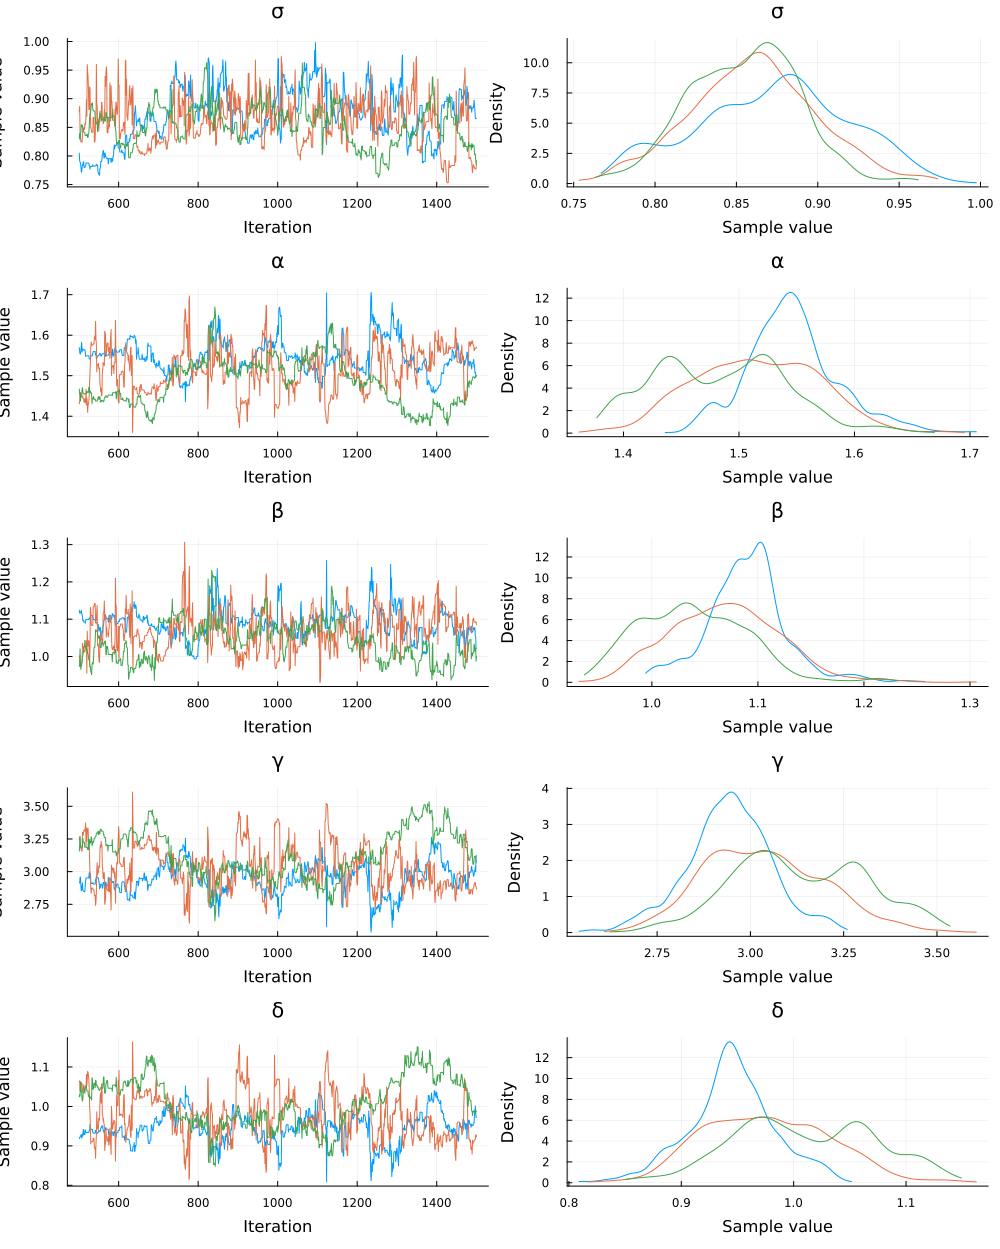

In [7]:
plot(chain)

Great! From our data we have arrived at a probability distribution for the
our parameter values.

## Evaluating Model Hypotheses with the Koopman Expectation

Now let's try and ask a question: what is the expected value of `x` (the first
term in the differential equation) at time `t=10` given the known uncertainties
in our parameters? This is a good tutorial question because all other probabilistic
statements can be phrased similarly. Asking a question like, "what is the probability
that `x(T) > 1` at the final time `T`?", can similarly be phrased as an expected
value (probability statements are expected values of characteristic functions
which are 1 if true 0 if false). So in general, the kinds of questions we want
to ask and answer are expectations about the solutions of the differential equation.

The trivial to solve this problem is to sample 100,000 sets of parameters from
our parameter distribution given by the Bayesian estimation, solve the ODE
100,000 times, and then take the average. But is 100,000 ODE solves enough?
Well it's hard to tell, and even then, the convergence of this approach is slow.
This is the Monte Carlo approach and it converges to the correct answer by
`sqrt(N)`. Slow.

However, the [Koopman expectation](https://arxiv.org/abs/2008.08737) can converge
with much fewer points, allowing the use of higher order quadrature methods to
converge exponentially faster in many cases. To use the Koopman expectation
functionality provided by [DiffEqUncertainty.jl](https://github.com/SciML/DiffEqUncertainty.jl),
we first need to define our observable function `g`. This function designates the
thing about the solution we wish to calculate the expectation of. Thus for our
question "what is the expected value of `x`at time `t=10`?", we would simply use:

In [8]:
function g(sol)
    sol[1,end]
end

g (generic function with 1 method)

Now we need to use the `expectation` call, where we need to provide our initial
condition and parameters as probability distirbutions. For this case, we will use
the same constant `u0` as before. But, let's turn our Bayesian MCMC chains into
distributions through [kernel density estimation](https://github.com/JuliaStats/KernelDensity.jl)
(the plots of the distribution above are just KDE plots!).

In [9]:
p_kde = [kde(vec(Array(chain[:α]))),kde(vec(Array(chain[:β]))),
         kde(vec(Array(chain[:γ]))),kde(vec(Array(chain[:δ])))]

4-element Vector{UnivariateKDE{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}:
 UnivariateKDE{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}(1.3186824900397434:0.00020917650269217637:1.7468667910506284, [1.1214504408219028e-5, 1.1038086702885863e-5, 1.093163808807418e-5, 1.0894389471882704e-5, 1.0925894490032562e-5, 1.102602649627471e-5, 1.1194976407669088e-5, 1.1433251414061374e-5, 1.1741674517118383e-5, 1.2121384916685685e-5  …  1.7237399058261937e-5, 1.624405810060625e-5, 1.5347426951362042e-5, 1.4543146652917782e-5, 1.3827260693419219e-5, 1.3196202851464833e-5, 1.2646785980396924e-5, 1.2176191748800025e-5, 1.1781961312073985e-5, 1.1461986912417177e-5])
 UnivariateKDE{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}(0.8933093101432259:0.0002201563892906344:1.3439694390211545, [1.5050142310624182e-5, 1.5730283814185952e-5, 1.6544439417121026e-5, 1.7498647645

Now that we have our observable and our uncertainty distributions, let's calculate
the expected value:

In [11]:
expect = expectation(g, prob1, u0, p_kde, Koopman(), Tsit5(), quadalg = CubaCuhre())

UndefVarError: UndefVarError: CubaCuhre not defined

Note how that gives the expectation and a residual for the error bound!

In [12]:
expect.resid

UndefVarError: UndefVarError: expect not defined

### GPU-Accelerated Expectations

Are we done? No, we need to add some GPUs! As mentioned earlier, probability
calculations can take quite a bit of ODE solves, so let's parallelize across
the parameters. [DiffEqGPU.jl](https://github.com/SciML/DiffEqGPU.jl) allows you
to GPU-parallelize across parameters by using the
[Ensemble interface](https://diffeq.sciml.ai/stable/features/ensemble/). Note that
you do not have to do any of the heavy lifting: all of the conversion to GPU
kernels is done automaticaly by simply specifying `EnsembleGPUArray` as the
ensembling method. For example:

In [ ]:
function lotka_volterra(du,u,p,t)
  @inbounds begin
      x = u[1]
      y = u[2]
      α = p[1]
      β = p[2]
      γ = p[3]
      δ = p[4]
      du[1] = (α - β*y)*x
      du[2] = (δ*x - γ)*y
  end
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
prob_func = (prob,i,repeat) -> remake(prob,p=rand(Float64,4).*p)
monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy=false)
@time sol = solve(monteprob,Tsit5(),EnsembleGPUArray(),trajectories=10_000,saveat=1.0f0)

Let's now use this in the ensembling method. We need to specify a `batch` for the
number of ODEs solved at the same time, and pass in our enembling method. The
following is a GPU-accelerated uncertainty quanitified estimate of the expectation
of the solution:

In [ ]:
expectation(g, prob1, u0, p_kde, Koopman(), Tsit5(), EnsembleGPUArray(), batch=100, quadalg = CubaCuhre())

In [ ]:
using SciMLTutorials
SciMLTutorials.tutorial_footer(WEAVE_ARGS[:folder],WEAVE_ARGS[:file])